In [34]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from env import get_db_url
import acquire
import prepare

- Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.
- Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.
- Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [105]:
df = pd.read_sql("""SELECT * FROM grocery_customers""",get_db_url('grocery_db'), index_col = 'customer_id')
df.columns = [col.lower() for col in df]

In [106]:
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [107]:
frozen_deli_paper = df[['frozen','delicassen','detergents_paper']]

In [108]:
# Scale data to help keep relationships between features intact
scaler = MinMaxScaler()

scaler.fit(frozen_deli_paper)

# Use scaler
frozen_deli_paper = scaler.transform(frozen_deli_paper)

In [109]:
dbsc = DBSCAN(eps = 0.10, min_samples=40)
dbsc.fit(frozen_deli_paper)

DBSCAN(eps=0.1, min_samples=40)

In [110]:
# Add scaled value columns back onto the dataframe
columns = ['frozen','delicassen','detergents_paper']
scaled_columns = ['scaled_'+c for c in columns]

original_df = df.copy()

scaled_df = pd.DataFrame(frozen_deli_paper, columns=scaled_columns)

# Merge scaled and nonscaled values
df = df.merge(scaled_df, on = df.index)
df = df.drop(columns=['key_0'])

In [111]:
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen,scaled_frozen,scaled_delicassen,scaled_detergents_paper
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.027847,0.065427
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.036984,0.080590
2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.163559,0.086052
3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.037234,0.012346
4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.108093,0.043455


In [112]:
df['labels'] = dbsc.labels_
df.labels = df.labels.astype('category')

<AxesSubplot:xlabel='frozen', ylabel='delicassen'>

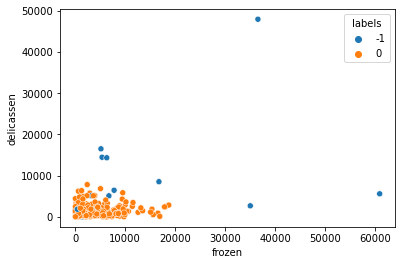

In [113]:
sns.scatterplot(df.frozen, df.delicassen, hue=df.labels)

<AxesSubplot:xlabel='detergents_paper', ylabel='delicassen'>

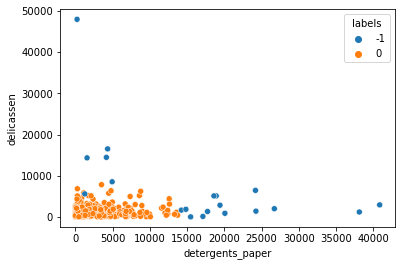

In [114]:
sns.scatterplot(df.detergents_paper, df.delicassen, hue=df.labels)

<AxesSubplot:xlabel='detergents_paper', ylabel='frozen'>

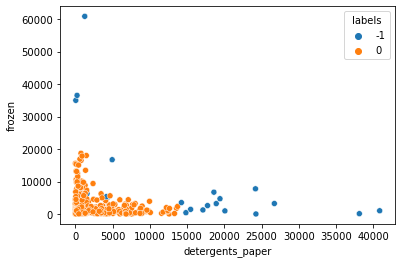

In [115]:
sns.scatterplot(df.detergents_paper, df.frozen, hue=df.labels)

Text(0.5, 0, 'Detergents')

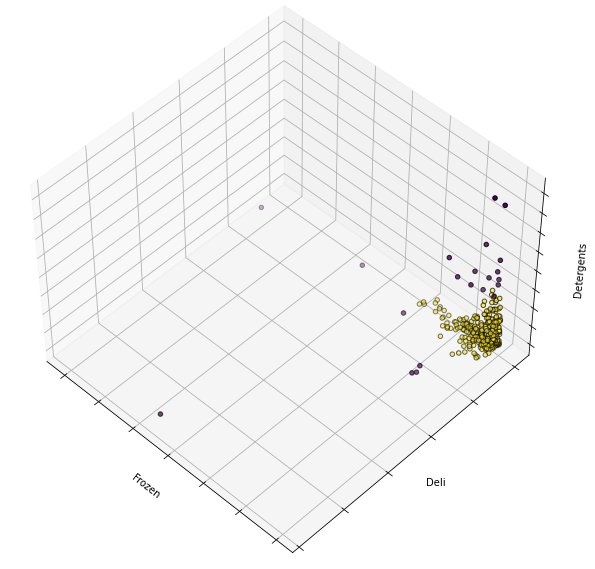

In [116]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.frozen, df.delicassen, df.detergents_paper,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Deli')
ax.set_zlabel('Detergents')


Deli anomalies detected

# Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.



In [118]:
df = acquire.acquire()

In [119]:
df = prepare.prepare_curriculum(df)

In [120]:
df.head()

,date,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,2018-01-26,/,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [121]:
daily_unique = df.resample('d').nunique()

In [122]:
daily_unique.head()

,date,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,1,104,50,8,13
2018-01-27,1,86,18,4,20
2018-01-28,1,57,19,4,20
2018-01-29,1,98,61,8,27
2018-01-30,1,118,61,10,31


<AxesSubplot:xlabel='path', ylabel='ip'>

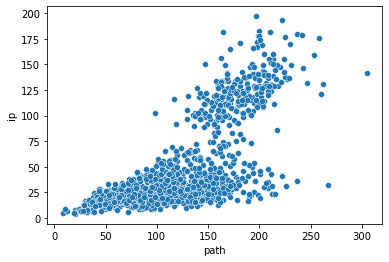

In [123]:
sns.scatterplot(data = daily_unique, x ='path', y='ip')

In [124]:
# Scale
scaler = MinMaxScaler()

scaler.fit(daily_unique[['path','ip']])

scaled_daily_unique = scaler.transform(daily_unique[['path','ip']])

scaled_columns = ["scaled_"+c for c in daily_unique[['path','ip']]]

In [143]:
# DBSCAN
dbsc = DBSCAN(eps = 0.1, min_samples=20)
dbsc.fit(pd.DataFrame(scaled_daily_unique, columns = scaled_columns, index = daily_unique.index))

DBSCAN(eps=0.1, min_samples=20)

In [144]:
daily_unique = pd.concat([daily_unique,pd.DataFrame(scaled_daily_unique, columns = scaled_columns, index = daily_unique.index)],axis=1)

In [145]:
daily_unique['clusters'] = dbsc.labels_

In [146]:
daily_unique.clusters = daily_unique.clusters.astype('category')

In [147]:
daily_unique.clusters.unique()

[0, -1]
Categories (2, int64): [-1, 0]

<AxesSubplot:xlabel='cohort_id', ylabel='ip'>

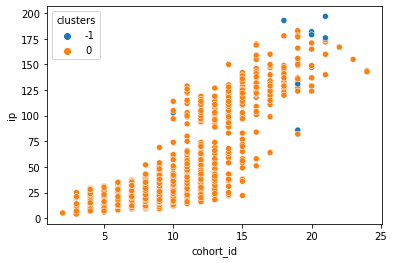

In [148]:
sns.scatterplot(data = daily_unique, x = 'cohort_id', y='ip', hue = 'clusters')

In [149]:
import wrangle_zillow

In [226]:
zil = wrangle_zillow.wrangle_zillow()


Using cached data


In [227]:
zil = zil[['bedroom','square_feet']]

In [228]:
zil = zil.dropna()

In [229]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(zil)

scaled_columns = ["scaled_"+c for c in zil]

In [230]:
zil = pd.concat([pd.DataFrame(scaled_data, columns = scaled_columns, index = zil.index),zil], axis=1)

In [232]:
dbsc = DBSCAN(eps=0.2, min_samples=500)

dbsc.fit(zil[scaled_columns])

DBSCAN(eps=0.2, min_samples=500)

In [233]:
zil['clusters'] = dbsc.labels_
zil.clusters = zil.clusters.astype('category')

<AxesSubplot:xlabel='scaled_bedroom', ylabel='scaled_square_feet'>

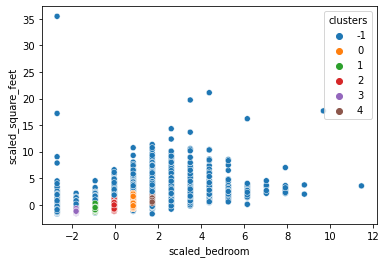

In [234]:
sns.scatterplot(data = zil, x = 'scaled_bedroom', y='scaled_square_feet', hue = 'clusters')

Clustering seems to exclude far more than just the outliers